In [116]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [117]:
t_all = 10 # [с]

L = 0.01 # [м]
N_x = int(1e3)
dx = L/N_x # [м]

In [118]:
# Теплофизические свойства железа Fe
# https://portal.tpu.ru/SHARED/s/STZIBULSKY/academic/Tab2/Teploprovodnost_mat.pdf

# Температура T[K]
T_Fe = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1300, 1400])

# Плотность ro[кг/м^3]
ro_Fe = np.array([7.868, 7.864, 7.860, 7.856, 7.852, np.nan, np.nan, np.nan, np.nan, 7.835, np.nan, np.nan, 7.820])*1000

# Удельная теплоёмкость cp[Дж/(кг*K)]
cp_Fe = np.array([0.358, 0.403, 0.446, 0.491, 0.535, 0.580, 0.625, 0.670, 0.715, 0.758, 0.557, 0.592, 0.626])*1000

# Теплопроводность lamda[Вт/(м*K)]
lamda_Fe = np.array([98, 87, 77, 68, 60, 55, 50, 45, 42, 41, 40, 39, 39])


# Исключаем NaN
valid_ro_Fe = ~np.isnan(ro_Fe)
valid_cp_Fe = ~np.isnan(cp_Fe)
valid_lamda_Fe = ~np.isnan(lamda_Fe)

# Функции интерполяции
ro_Fe_interp = CubicSpline(T_Fe[valid_ro_Fe], ro_Fe[valid_ro_Fe])
cp_Fe_interp = CubicSpline(T_Fe[valid_cp_Fe], cp_Fe[valid_cp_Fe])
lamda_Fe_interp = CubicSpline(T_Fe[valid_lamda_Fe], lamda_Fe[valid_lamda_Fe])

In [119]:
def roT(T):
    return ro_Fe_interp(T)

def cpT(T):
    return cp_Fe_interp(T)

def lamdaT(T):
    return lamda_Fe_interp(T)

def dlamdadT(T):
    return lamda_Fe_interp(T,1)

In [120]:
# Координатные зависимости

xi = np.arange(0, L+dx, dx)

# Площадь сечения S[м^2]
S_coef = 1e-4 # [м^2]
x_dat_S = np.array([0, L/2, L])
S_dat = np.array([1, 1, 1])*S_coef
S_int = interp1d(x_dat_S, S_dat, kind="quadratic", fill_value="extrapolate")
Si = S_int(xi)

# Начальная температура T0[К]
T0_coef = 300 # [К]
x_dat_T0 = np.array([0, L/2, L])
T0_dat = np.array([1, 1, 1])*T0_coef
T0 = interp1d(x_dat_T0, T0_dat, kind="quadratic", fill_value="extrapolate")(xi)



# Плотность
x_dat_ro = np.array([0, L/2, L])
ro_dat = np.array([1, 1, 1])
ro_xi = interp1d(x_dat_ro, ro_dat, kind="quadratic", fill_value="extrapolate")(xi)

# Удельная теплоёмкость
x_dat_cp = np.array([0, L/2, L])
cp_dat = np.array([1, 1, 1])
cp_xi = interp1d(x_dat_cp, cp_dat, kind="quadratic", fill_value="extrapolate")(xi)

# Теплопроводность
x_dat_lamda = np.array([0, L/2, L])
lamda_dat = np.array([1, 1, 1])
lamda_int = interp1d(x_dat_lamda, lamda_dat, kind="quadratic", fill_value="extrapolate")
lamda_xi = lamda_int(xi)

In [121]:
def LeftBC(t,y):
  # Граничное условие 2-го рода
  q_left = 1e5 # [Вт/м^2]

  ym1 = y[1] + (2*dx*q_left)/(lamdaT(y[0])*lamda_xi[0])
  
  Kr = lamdaT(y[1])*lamda_xi[1] + lamdaT(y[0])*lamda_xi[0]*(Si[1]/Si[0] - S_int(-dx)/Si[0]) - lamdaT(ym1)*lamda_int(-dx)
  CRO = dx**2 * cpT(y[0]) * cp_xi[0] * roT(y[0]) * ro_xi[0]


  Ldydt = (4*lamdaT(y[0])*lamda_xi[0] + Kr)/(4*CRO) * y[1] - (2*lamdaT(y[0])*lamda_xi[0])/CRO * y[0] + (4*lamdaT(y[0])*lamda_xi[0] - Kr)/(4*CRO) * ym1 + (dlamdadT(y[0])*lamda_xi[0])/(4*CRO) * (y[1]-ym1)**2

  return Ldydt, y[0]

In [75]:
def LeftBC(t,y):
  # Граничное условие 1-го рода
  T_const = 400 # [К]
  Ldydt = 0

  return Ldydt, T_const

In [122]:
def RightBC(t,y):
  # Граничное условие 1-го рода
  T_const = 300 # [К]
  Rdydt =  0

  return Rdydt, T_const

In [123]:
def system(t, y):

  #pbar.n = t
  #pbar.set_description(f"Время: {t:.4e} сек")
  #pbar.set_postfix({
  #  'Текущее': f'{t:.2e}',
  #  #'Шаг': f'{time_step:.2e}',
  #  'Прогресс': f'{((t - 0)/(t_all-0))*100:.1f}%'
  #})
  

  # y = [U0, U1, ... ,UN_x]

  Kr = lamdaT(y[2:N_x+1])*lamda_xi[2:N_x+1] + lamdaT(y[1:N_x])*lamda_xi[1:N_x]*(Si[2:N_x+1]/Si[1:N_x] - Si[0:N_x-1]/Si[1:N_x]) - lamdaT(y[0:N_x-1])*lamda_xi[0:N_x-1]
  CRO = dx**2 * cpT(y[1:N_x]) * cp_xi[1:N_x] * roT(y[1:N_x]) * ro_xi[1:N_x]

  dydt = np.zeros(N_x+1)

  dydt[0], y[0] = LeftBC(t,y)
  dydt[N_x], y[N_x] = RightBC(t,y)

  dydt[1:N_x] = (4*lamdaT(y[1:N_x])*lamda_xi[1:N_x] + Kr)/(4*CRO) * y[2:N_x+1] - (2*lamdaT(y[1:N_x])*lamda_xi[1:N_x])/CRO * y[1:N_x] + (4*lamdaT(y[1:N_x])*lamda_xi[1:N_x] - Kr)/(4*CRO) * y[0:N_x-1] + (dlamdadT(y[1:N_x])*lamda_xi[1:N_x])/(4*CRO) * (y[2:N_x+1]-y[0:N_x-1])**2

  return dydt

In [124]:
U0 = np.ones(N_x+1)*300 # [К]

t_span = (0, t_all)
t_eval = np.linspace(0, t_all, int(5e2)+1)

#pbar = tqdm(total=t_all - 0, 
#            desc="Время выполнения",
#            bar_format='{desc}: {percentage:.1f}% | {n:.4e}/{total:.2e} [{elapsed}]')


solution = solve_ivp(system, t_span, U0, t_eval=t_eval, method='BDF', rtol=1e-4, atol=1e-10)

#pbar.close()

#data_t = solution.t
#data = solution.y

#dat = pd.DataFrame(data)

In [125]:
solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.000e-02 ...  9.980e+00  1.000e+01]
        y: [[ 3.000e+02  3.009e+02 ...  3.129e+02  3.129e+02]
            [ 3.000e+02  3.009e+02 ...  3.129e+02  3.129e+02]
            ...
            [ 3.000e+02  3.000e+02 ...  3.000e+02  3.000e+02]
            [ 3.000e+02  3.000e+02 ...  3.000e+02  3.000e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 72
     njev: 1
      nlu: 14

In [126]:
pd.DataFrame(solution.y)

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,300.0,300.939214,301.355391,301.673833,301.939671,302.169382,302.379823,302.575527,302.751192,302.920004,...,312.935862,312.936340,312.936817,312.937292,312.937766,312.938241,312.938717,312.939194,312.939674,312.940159
1,300.0,300.926273,301.342422,301.660851,301.926681,302.156386,302.366821,302.562520,302.738180,302.906989,...,312.922668,312.923147,312.923623,312.924098,312.924573,312.925047,312.925523,312.926000,312.926481,312.926965
2,300.0,300.913453,301.329535,301.647933,301.913746,302.143439,302.353864,302.549554,302.725209,302.894011,...,312.909475,312.909954,312.910430,312.910905,312.911379,312.911854,312.912330,312.912807,312.913287,312.913771
3,300.0,300.900756,301.316727,301.635079,301.900866,302.130543,302.340953,302.536631,302.712276,302.881070,...,312.896282,312.896761,312.897237,312.897712,312.898187,312.898661,312.899137,312.899614,312.900095,312.900579
4,300.0,300.888180,301.304000,301.622289,301.888041,302.117696,302.328088,302.523749,302.699382,302.868165,...,312.883090,312.883569,312.884045,312.884520,312.884995,312.885469,312.885945,312.886422,312.886902,312.887387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,300.0,300.000000,300.000000,300.000000,300.000001,300.000002,300.000007,300.000019,300.000034,300.000065,...,300.050823,300.050826,300.050829,300.050832,300.050835,300.050838,300.050841,300.050844,300.050847,300.050850
997,300.0,300.000000,300.000000,300.000000,300.000000,300.000001,300.000005,300.000014,300.000026,300.000049,...,300.038116,300.038119,300.038121,300.038123,300.038125,300.038128,300.038130,300.038132,300.038134,300.038137
998,300.0,300.000000,300.000000,300.000000,300.000000,300.000001,300.000004,300.000009,300.000017,300.000033,...,300.025411,300.025412,300.025414,300.025415,300.025417,300.025418,300.025419,300.025421,300.025422,300.025424
999,300.0,300.000000,300.000000,300.000000,300.000000,300.000000,300.000002,300.000005,300.000009,300.000016,...,300.012705,300.012706,300.012707,300.012707,300.012708,300.012709,300.012710,300.012710,300.012711,300.012712


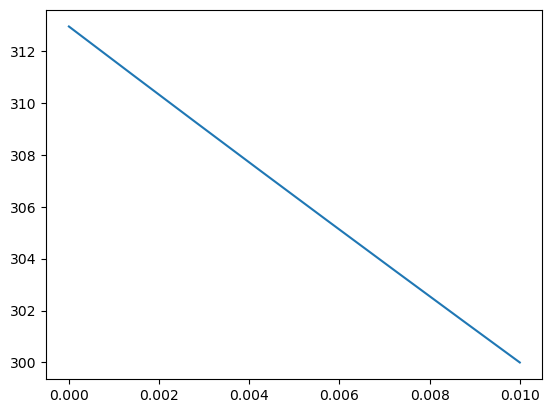

In [133]:
plt.plot(xi, solution.y[:,-1])
plt.show()

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


fig, ax = plt.subplots(figsize=(10, 6))
x = xi
line, = ax.plot([], [], 'b-', linewidth=2)

ax.set_xlim(xi[0], xi[-1])
ax.set_ylim(np.min(solution.y), np.max(solution.y))
ax.grid(True)
ax.set_title('Нагрев образца')

def animate(frame):
  y = solution.y[:,frame]
  line.set_data(x, y)
  ax.set_title(f'Нагрев образца - кадр {frame}')
  return line,

ani = FuncAnimation(fig, animate, frames=150, interval=50, blit=True)

print("Сохранение анимации...")
ani.save('heating_animation_main.gif', writer=PillowWriter(fps=20))
print("Анимация сохранена как 'heating_animation.gif'")

Сохранение анимации...
Анимация сохранена как 'heating_animation.gif'
